---
### Imports

In [101]:
import pandas as pd
import torch
from torchmetrics import Accuracy, F1Score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from tqdm import tqdm

---
### Load Dataset
##### Train:

In [102]:
data_frame_train = pd.read_csv('./dataset/train.csv')
x = data_frame_train.drop('price_range', axis=1)
y = data_frame_train['price_range']

In [103]:
x

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1
1997,1911,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0
1998,1512,0,0.9,0,4,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1


In [104]:
y

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64

In [105]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7, random_state=42)

In [106]:
x_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
836,902,1,0.6,1,0,0,63,0.7,122,5,14,364,1360,3654,18,8,15,0,1,1
575,1197,1,0.5,1,9,0,20,0.1,129,5,10,214,1710,2885,19,7,14,1,1,1
557,1519,0,2.1,0,0,0,32,0.7,200,1,10,168,1239,2912,11,10,15,1,1,0
1235,1971,1,0.5,1,0,0,40,0.3,186,7,19,485,922,571,8,7,17,1,1,0
1360,882,0,0.7,1,9,1,28,0.2,151,6,16,248,884,751,19,11,8,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1975,1,1.9,1,2,0,31,0.9,151,1,17,775,1607,3022,13,5,19,0,0,1
1294,589,1,0.5,0,1,1,59,0.7,146,8,4,759,1858,362,16,10,6,1,1,1
860,1829,1,0.5,0,0,1,15,0.4,160,5,7,729,1267,2080,16,11,12,1,0,1
1459,1927,0,0.9,1,3,0,11,0.4,190,8,12,491,1506,2916,16,11,18,0,1,1


---
### Preprocessing

In [107]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

In [108]:
x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

---
### Normalization (Standardization)

In [109]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

---
### Dataloader

In [110]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=600, shuffle=True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=800, shuffle=False)

---
### Define Model

In [111]:
num_feats = 20
out_feats = 4
h1 = 64
h2 = 32

model = torch.nn.Sequential(torch.nn.Linear(num_feats, h1),
                            torch.nn.ReLU(),
                            # torch.nn.Dropout(0.5),
                            torch.nn.Linear(h1, h2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h2, out_feats))
model

Sequential(
  (0): Linear(in_features=20, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
)

---
### Device

In [112]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
device

'cuda'

---
### Loss Function

In [113]:
loss_fn = torch.nn.CrossEntropyLoss()

---
### Optimizer

In [114]:
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            momentum=0.9,
                            nesterov=True,
                            weight_decay=1e-4)

---
### AverageMeter

In [115]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

---
### Methods of train and validate model:

In [116]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes=4).to(device)
    f1_train = F1Score(task="multiclass", num_classes=4).to(device)

    with tqdm(train_loader, unit='batch') as t_loader:
        for data, target in t_loader:
            data = data.to(device)
            target = target.to(device)

            predict = model(data)
            loss = loss_fn(predict.squeeze(), target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item())
            acc_train(predict, target)
            f1_train(predict, target)

            t_loader.set_description(f"Epoch: {epoch}")
            t_loader.set_postfix(loss=loss_train.avg,
                                 accuracy=f"{(acc_train.compute().cpu().item() * 100):.4}%",
                                 f1=f"{(f1_train.compute().cpu().item() * 100):.4}%")

    return model, loss_train.avg, acc_train.compute(), f1_train.compute()

In [117]:
def valid_one_epoch(model, valid_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task="multiclass", num_classes=4).to(device)
        f1_valid = F1Score(task="multiclass", num_classes=4).to(device)
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)

            predict = model(data)
            loss = loss_fn(predict.squeeze(), target)

            loss_valid.update(loss.item())
            acc_valid(predict, target)
            f1_valid(predict, target)

    return loss_valid.avg, acc_valid.compute(), f1_valid.compute()


---
### Train

In [118]:
epochs = 100

In [119]:
hist_loss_train = []
hist_loss_valid = []

hist_acc_train = []
hist_acc_valid = []

hist_f1_train = []
hist_f1_valid = []

In [120]:
for epoch in range(epochs):
    model, loss_train, acc_train, f1_train = train_one_epoch(model=model,
                                                             train_loader=train_loader,
                                                             loss_fn=loss_fn,
                                                             optimizer=optimizer,
                                                             epoch=epoch)

    loss_valid, acc_valid, f1_valid = valid_one_epoch(model=model, valid_loader=valid_loader, loss_fn=loss_fn)

    hist_loss_train.append(loss_train)
    hist_loss_valid.append(loss_valid)

    hist_acc_train.append(acc_train.cpu())
    hist_acc_valid.append(acc_valid.cpu())

    hist_f1_train.append(f1_train.cpu())
    hist_f1_valid.append(f1_valid.cpu())

    print(f"Loss_valid: {loss_valid:.4}, Accuracy_valid: {(acc_valid * 100):.4}%, F1_valid: {(f1_valid * 100):.4}%")

Epoch: 0: 100%|██████████| 3/3 [00:00<00:00, 46.25batch/s, accuracy=20.79%, f1=20.79%, loss=1.42]


Loss_valid: 1.415, Accuracy_valid: 19.0%, F1_valid: 19.0%


Epoch: 1: 100%|██████████| 3/3 [00:00<00:00, 28.42batch/s, accuracy=20.57%, f1=20.57%, loss=1.41]


Loss_valid: 1.409, Accuracy_valid: 20.17%, F1_valid: 20.17%


Epoch: 2: 100%|██████████| 3/3 [00:00<00:00, 42.25batch/s, accuracy=21.64%, f1=21.64%, loss=1.41]


Loss_valid: 1.401, Accuracy_valid: 22.0%, F1_valid: 22.0%


Epoch: 3: 100%|██████████| 3/3 [00:00<00:00, 46.15batch/s, accuracy=23.0%, f1=23.0%, loss=1.4]


Loss_valid: 1.393, Accuracy_valid: 23.5%, F1_valid: 23.5%


Epoch: 4: 100%|██████████| 3/3 [00:00<00:00, 45.46batch/s, accuracy=25.5%, f1=25.5%, loss=1.39]


Loss_valid: 1.387, Accuracy_valid: 25.67%, F1_valid: 25.67%


Epoch: 5: 100%|██████████| 3/3 [00:00<00:00, 38.96batch/s, accuracy=28.21%, f1=28.21%, loss=1.38]


Loss_valid: 1.38, Accuracy_valid: 28.67%, F1_valid: 28.67%


Epoch: 6: 100%|██████████| 3/3 [00:00<00:00, 36.36batch/s, accuracy=30.29%, f1=30.29%, loss=1.38]


Loss_valid: 1.375, Accuracy_valid: 30.33%, F1_valid: 30.33%


Epoch: 7: 100%|██████████| 3/3 [00:00<00:00, 37.73batch/s, accuracy=32.29%, f1=32.29%, loss=1.37]


Loss_valid: 1.37, Accuracy_valid: 30.67%, F1_valid: 30.67%


Epoch: 8: 100%|██████████| 3/3 [00:00<00:00, 50.41batch/s, accuracy=34.57%, f1=34.57%, loss=1.37]


Loss_valid: 1.365, Accuracy_valid: 32.5%, F1_valid: 32.5%


Epoch: 9: 100%|██████████| 3/3 [00:00<00:00, 39.19batch/s, accuracy=36.21%, f1=36.21%, loss=1.36]


Loss_valid: 1.36, Accuracy_valid: 35.17%, F1_valid: 35.17%


Epoch: 10: 100%|██████████| 3/3 [00:00<00:00, 40.81batch/s, accuracy=36.36%, f1=36.36%, loss=1.36]


Loss_valid: 1.354, Accuracy_valid: 36.5%, F1_valid: 36.5%


Epoch: 11: 100%|██████████| 3/3 [00:00<00:00, 41.30batch/s, accuracy=37.07%, f1=37.07%, loss=1.35]


Loss_valid: 1.348, Accuracy_valid: 37.17%, F1_valid: 37.17%


Epoch: 12: 100%|██████████| 3/3 [00:00<00:00, 45.09batch/s, accuracy=39.14%, f1=39.14%, loss=1.34]

Loss_valid: 1.342, Accuracy_valid: 39.83%, F1_valid: 39.83%

Epoch: 13: 100%|██████████| 3/3 [00:00<00:00, 52.16batch/s, accuracy=41.36%, f1=41.36%, loss=1.33]


Loss_valid: 1.334, Accuracy_valid: 40.67%, F1_valid: 40.67%


Epoch: 14: 100%|██████████| 3/3 [00:00<00:00, 43.14batch/s, accuracy=43.36%, f1=43.36%, loss=1.33]


Loss_valid: 1.325, Accuracy_valid: 42.67%, F1_valid: 42.67%


Epoch: 15: 100%|██████████| 3/3 [00:00<00:00, 47.95batch/s, accuracy=44.5%, f1=44.5%, loss=1.32]

Loss_valid: 1.316, Accuracy_valid: 42.67%, F1_valid: 42.67%

Epoch: 16: 100%|██████████| 3/3 [00:00<00:00, 93.76batch/s, accuracy=45.93%, f1=45.93%, loss=1.31]


Loss_valid: 1.305, Accuracy_valid: 44.5%, F1_valid: 44.5%


Epoch: 17: 100%|██████████| 3/3 [00:00<00:00, 82.76batch/s, accuracy=46.07%, f1=46.07%, loss=1.3]

Loss_valid: 1.292, Accuracy_valid: 45.5%, F1_valid: 45.5%



Epoch: 18: 100%|██████████| 3/3 [00:00<00:00, 85.71batch/s, accuracy=47.64%, f1=47.64%, loss=1.28]


Loss_valid: 1.278, Accuracy_valid: 46.67%, F1_valid: 46.67%


Epoch: 19: 100%|██████████| 3/3 [00:00<00:00, 89.52batch/s, accuracy=48.43%, f1=48.43%, loss=1.27]


Loss_valid: 1.263, Accuracy_valid: 47.33%, F1_valid: 47.33%


Epoch: 20: 100%|██████████| 3/3 [00:00<00:00, 96.75batch/s, accuracy=49.57%, f1=49.57%, loss=1.25]


Loss_valid: 1.245, Accuracy_valid: 48.67%, F1_valid: 48.67%


Epoch: 21: 100%|██████████| 3/3 [00:00<00:00, 101.55batch/s, accuracy=50.64%, f1=50.64%, loss=1.23]


Loss_valid: 1.226, Accuracy_valid: 49.33%, F1_valid: 49.33%


Epoch: 22: 100%|██████████| 3/3 [00:00<00:00, 85.68batch/s, accuracy=51.43%, f1=51.43%, loss=1.21]


Loss_valid: 1.205, Accuracy_valid: 50.17%, F1_valid: 50.17%


Epoch: 23: 100%|██████████| 3/3 [00:00<00:00, 86.93batch/s, accuracy=52.0%, f1=52.0%, loss=1.19]


Loss_valid: 1.181, Accuracy_valid: 50.5%, F1_valid: 50.5%


Epoch: 24: 100%|██████████| 3/3 [00:00<00:00, 96.77batch/s, accuracy=52.36%, f1=52.36%, loss=1.17]


Loss_valid: 1.156, Accuracy_valid: 51.67%, F1_valid: 51.67%


Epoch: 25: 100%|██████████| 3/3 [00:00<00:00, 75.99batch/s, accuracy=53.14%, f1=53.14%, loss=1.14]


Loss_valid: 1.128, Accuracy_valid: 52.83%, F1_valid: 52.83%


Epoch: 26: 100%|██████████| 3/3 [00:00<00:00, 90.89batch/s, accuracy=53.64%, f1=53.64%, loss=1.12]


Loss_valid: 1.1, Accuracy_valid: 53.0%, F1_valid: 53.0%


Epoch: 27: 100%|██████████| 3/3 [00:00<00:00, 100.01batch/s, accuracy=54.64%, f1=54.64%, loss=1.08]


Loss_valid: 1.069, Accuracy_valid: 53.33%, F1_valid: 53.33%


Epoch: 28: 100%|██████████| 3/3 [00:00<00:00, 88.15batch/s, accuracy=55.07%, f1=55.07%, loss=1.05]


Loss_valid: 1.037, Accuracy_valid: 54.0%, F1_valid: 54.0%


Epoch: 29: 100%|██████████| 3/3 [00:00<00:00, 85.72batch/s, accuracy=55.79%, f1=55.79%, loss=1.01]


Loss_valid: 1.005, Accuracy_valid: 54.83%, F1_valid: 54.83%


Epoch: 30: 100%|██████████| 3/3 [00:00<00:00, 85.70batch/s, accuracy=56.36%, f1=56.36%, loss=0.996]


Loss_valid: 0.9727, Accuracy_valid: 56.0%, F1_valid: 56.0%


Epoch: 31: 100%|██████████| 3/3 [00:00<00:00, 93.75batch/s, accuracy=57.0%, f1=57.0%, loss=0.962]


Loss_valid: 0.9405, Accuracy_valid: 57.83%, F1_valid: 57.83%


Epoch: 32: 100%|██████████| 3/3 [00:00<00:00, 95.20batch/s, accuracy=58.29%, f1=58.29%, loss=0.93]


Loss_valid: 0.9088, Accuracy_valid: 60.17%, F1_valid: 60.17%


Epoch: 33: 100%|██████████| 3/3 [00:00<00:00, 93.74batch/s, accuracy=59.86%, f1=59.86%, loss=0.895]


Loss_valid: 0.8778, Accuracy_valid: 62.0%, F1_valid: 62.0%


Epoch: 34: 100%|██████████| 3/3 [00:00<00:00, 89.50batch/s, accuracy=61.79%, f1=61.79%, loss=0.861]


Loss_valid: 0.8478, Accuracy_valid: 64.67%, F1_valid: 64.67%


Epoch: 35: 100%|██████████| 3/3 [00:00<00:00, 93.75batch/s, accuracy=63.79%, f1=63.79%, loss=0.842]


Loss_valid: 0.8189, Accuracy_valid: 66.5%, F1_valid: 66.5%


Epoch: 36: 100%|██████████| 3/3 [00:00<00:00, 79.96batch/s, accuracy=66.14%, f1=66.14%, loss=0.802]


Loss_valid: 0.7913, Accuracy_valid: 70.33%, F1_valid: 70.33%


Epoch: 37: 100%|██████████| 3/3 [00:00<00:00, 93.64batch/s, accuracy=68.5%, f1=68.5%, loss=0.768]


Loss_valid: 0.765, Accuracy_valid: 73.33%, F1_valid: 73.33%


Epoch: 38: 100%|██████████| 3/3 [00:00<00:00, 72.26batch/s, accuracy=71.36%, f1=71.36%, loss=0.748]


Loss_valid: 0.7399, Accuracy_valid: 74.67%, F1_valid: 74.67%


Epoch: 39: 100%|██████████| 3/3 [00:00<00:00, 96.77batch/s, accuracy=73.64%, f1=73.64%, loss=0.723]


Loss_valid: 0.7159, Accuracy_valid: 77.33%, F1_valid: 77.33%


Epoch: 40: 100%|██████████| 3/3 [00:00<00:00, 74.96batch/s, accuracy=75.93%, f1=75.93%, loss=0.706]


Loss_valid: 0.6932, Accuracy_valid: 79.33%, F1_valid: 79.33%


Epoch: 41: 100%|██████████| 3/3 [00:00<00:00, 93.67batch/s, accuracy=78.29%, f1=78.29%, loss=0.677]


Loss_valid: 0.6717, Accuracy_valid: 81.83%, F1_valid: 81.83%


Epoch: 42: 100%|██████████| 3/3 [00:00<00:00, 81.08batch/s, accuracy=80.79%, f1=80.79%, loss=0.657]


Loss_valid: 0.6512, Accuracy_valid: 83.33%, F1_valid: 83.33%


Epoch: 43: 100%|██████████| 3/3 [00:00<00:00, 54.04batch/s, accuracy=82.21%, f1=82.21%, loss=0.643]


Loss_valid: 0.6314, Accuracy_valid: 84.67%, F1_valid: 84.67%


Epoch: 44: 100%|██████████| 3/3 [00:00<00:00, 75.00batch/s, accuracy=84.36%, f1=84.36%, loss=0.61]


Loss_valid: 0.6124, Accuracy_valid: 85.0%, F1_valid: 85.0%


Epoch: 45: 100%|██████████| 3/3 [00:00<00:00, 85.71batch/s, accuracy=85.07%, f1=85.07%, loss=0.598]


Loss_valid: 0.5942, Accuracy_valid: 85.67%, F1_valid: 85.67%


Epoch: 46: 100%|██████████| 3/3 [00:00<00:00, 81.06batch/s, accuracy=85.64%, f1=85.64%, loss=0.588]


Loss_valid: 0.5769, Accuracy_valid: 86.0%, F1_valid: 86.0%


Epoch: 47: 100%|██████████| 3/3 [00:00<00:00, 81.08batch/s, accuracy=86.14%, f1=86.14%, loss=0.564]

Loss_valid: 0.5606, Accuracy_valid: 86.67%, F1_valid: 86.67%

Epoch: 48: 100%|██████████| 3/3 [00:00<00:00, 60.59batch/s, accuracy=87.36%, f1=87.36%, loss=0.544]


Loss_valid: 0.5448, Accuracy_valid: 87.0%, F1_valid: 87.0%


Epoch: 49: 100%|██████████| 3/3 [00:00<00:00, 43.13batch/s, accuracy=88.07%, f1=88.07%, loss=0.533]


Loss_valid: 0.5299, Accuracy_valid: 87.17%, F1_valid: 87.17%


Epoch: 50: 100%|██████████| 3/3 [00:00<00:00, 55.01batch/s, accuracy=89.0%, f1=89.0%, loss=0.51]


Loss_valid: 0.5156, Accuracy_valid: 88.17%, F1_valid: 88.17%


Epoch: 51: 100%|██████████| 3/3 [00:00<00:00, 83.33batch/s, accuracy=89.5%, f1=89.5%, loss=0.503]


Loss_valid: 0.5017, Accuracy_valid: 88.67%, F1_valid: 88.67%


Epoch: 52: 100%|██████████| 3/3 [00:00<00:00, 92.23batch/s, accuracy=89.93%, f1=89.93%, loss=0.488]

Loss_valid: 0.4886, Accuracy_valid: 89.0%, F1_valid: 89.0%



Epoch: 53: 100%|██████████| 3/3 [00:00<00:00, 93.75batch/s, accuracy=90.29%, f1=90.29%, loss=0.473]


Loss_valid: 0.476, Accuracy_valid: 89.17%, F1_valid: 89.17%


Epoch: 54: 100%|██████████| 3/3 [00:00<00:00, 95.21batch/s, accuracy=90.43%, f1=90.43%, loss=0.463]


Loss_valid: 0.4639, Accuracy_valid: 89.17%, F1_valid: 89.17%


Epoch: 55: 100%|██████████| 3/3 [00:00<00:00, 88.23batch/s, accuracy=90.79%, f1=90.79%, loss=0.448]


Loss_valid: 0.4523, Accuracy_valid: 90.17%, F1_valid: 90.17%


Epoch: 56: 100%|██████████| 3/3 [00:00<00:00, 67.36batch/s, accuracy=91.14%, f1=91.14%, loss=0.436]


Loss_valid: 0.4413, Accuracy_valid: 90.5%, F1_valid: 90.5%


Epoch: 57: 100%|██████████| 3/3 [00:00<00:00, 88.22batch/s, accuracy=91.43%, f1=91.43%, loss=0.429]


Loss_valid: 0.4304, Accuracy_valid: 90.67%, F1_valid: 90.67%


Epoch: 58: 100%|██████████| 3/3 [00:00<00:00, 96.77batch/s, accuracy=91.64%, f1=91.64%, loss=0.416]


Loss_valid: 0.42, Accuracy_valid: 90.17%, F1_valid: 90.17%


Epoch: 59: 100%|██████████| 3/3 [00:00<00:00, 74.99batch/s, accuracy=91.79%, f1=91.79%, loss=0.403]


Loss_valid: 0.4102, Accuracy_valid: 90.33%, F1_valid: 90.33%


Epoch: 60: 100%|██████████| 3/3 [00:00<00:00, 88.23batch/s, accuracy=91.71%, f1=91.71%, loss=0.399]


Loss_valid: 0.4009, Accuracy_valid: 90.33%, F1_valid: 90.33%


Epoch: 61: 100%|██████████| 3/3 [00:00<00:00, 89.44batch/s, accuracy=92.0%, f1=92.0%, loss=0.383]


Loss_valid: 0.392, Accuracy_valid: 90.17%, F1_valid: 90.17%


Epoch: 62: 100%|██████████| 3/3 [00:00<00:00, 85.73batch/s, accuracy=92.14%, f1=92.14%, loss=0.372]


Loss_valid: 0.3834, Accuracy_valid: 90.83%, F1_valid: 90.83%


Epoch: 63: 100%|██████████| 3/3 [00:00<00:00, 98.32batch/s, accuracy=92.71%, f1=92.71%, loss=0.37]


Loss_valid: 0.3751, Accuracy_valid: 91.17%, F1_valid: 91.17%


Epoch: 64: 100%|██████████| 3/3 [00:00<00:00, 88.24batch/s, accuracy=93.07%, f1=93.07%, loss=0.363]


Loss_valid: 0.367, Accuracy_valid: 91.17%, F1_valid: 91.17%


Epoch: 65: 100%|██████████| 3/3 [00:00<00:00, 89.52batch/s, accuracy=93.0%, f1=93.0%, loss=0.346]


Loss_valid: 0.3593, Accuracy_valid: 91.17%, F1_valid: 91.17%


Epoch: 66: 100%|██████████| 3/3 [00:00<00:00, 96.77batch/s, accuracy=93.36%, f1=93.36%, loss=0.338]


Loss_valid: 0.3521, Accuracy_valid: 91.33%, F1_valid: 91.33%


Epoch: 67: 100%|██████████| 3/3 [00:00<00:00, 86.94batch/s, accuracy=93.57%, f1=93.57%, loss=0.335]


Loss_valid: 0.3452, Accuracy_valid: 91.67%, F1_valid: 91.67%


Epoch: 68: 100%|██████████| 3/3 [00:00<00:00, 88.24batch/s, accuracy=93.71%, f1=93.71%, loss=0.321]


Loss_valid: 0.3387, Accuracy_valid: 91.67%, F1_valid: 91.67%


Epoch: 69: 100%|██████████| 3/3 [00:00<00:00, 98.33batch/s, accuracy=93.79%, f1=93.79%, loss=0.319]


Loss_valid: 0.3321, Accuracy_valid: 91.33%, F1_valid: 91.33%


Epoch: 70: 100%|██████████| 3/3 [00:00<00:00, 85.72batch/s, accuracy=94.07%, f1=94.07%, loss=0.309]


Loss_valid: 0.3259, Accuracy_valid: 91.17%, F1_valid: 91.17%


Epoch: 71: 100%|██████████| 3/3 [00:00<00:00, 103.45batch/s, accuracy=94.07%, f1=94.07%, loss=0.301]


Loss_valid: 0.3201, Accuracy_valid: 91.67%, F1_valid: 91.67%


Epoch: 72: 100%|██████████| 3/3 [00:00<00:00, 83.33batch/s, accuracy=94.29%, f1=94.29%, loss=0.297]


Loss_valid: 0.3145, Accuracy_valid: 92.17%, F1_valid: 92.17%


Epoch: 73: 100%|██████████| 3/3 [00:00<00:00, 93.75batch/s, accuracy=94.21%, f1=94.21%, loss=0.288]


Loss_valid: 0.3091, Accuracy_valid: 92.17%, F1_valid: 92.17%


Epoch: 74: 100%|██████████| 3/3 [00:00<00:00, 90.90batch/s, accuracy=94.43%, f1=94.43%, loss=0.284]


Loss_valid: 0.3037, Accuracy_valid: 92.0%, F1_valid: 92.0%


Epoch: 75: 100%|██████████| 3/3 [00:00<00:00, 75.00batch/s, accuracy=94.64%, f1=94.64%, loss=0.282]


Loss_valid: 0.2986, Accuracy_valid: 92.0%, F1_valid: 92.0%


Epoch: 76: 100%|██████████| 3/3 [00:00<00:00, 70.57batch/s, accuracy=94.79%, f1=94.79%, loss=0.273]


Loss_valid: 0.2939, Accuracy_valid: 92.33%, F1_valid: 92.33%


Epoch: 77: 100%|██████████| 3/3 [00:00<00:00, 69.77batch/s, accuracy=95.14%, f1=95.14%, loss=0.27]

Loss_valid: 0.2896, Accuracy_valid: 92.67%, F1_valid: 92.67%



Epoch: 78: 100%|██████████| 3/3 [00:00<00:00, 92.27batch/s, accuracy=95.14%, f1=95.14%, loss=0.265]


Loss_valid: 0.2856, Accuracy_valid: 92.33%, F1_valid: 92.33%


Epoch: 79: 100%|██████████| 3/3 [00:00<00:00, 100.01batch/s, accuracy=95.36%, f1=95.36%, loss=0.267]


Loss_valid: 0.2818, Accuracy_valid: 92.0%, F1_valid: 92.0%


Epoch: 80: 100%|██████████| 3/3 [00:00<00:00, 98.32batch/s, accuracy=95.5%, f1=95.5%, loss=0.251]


Loss_valid: 0.2778, Accuracy_valid: 92.17%, F1_valid: 92.17%


Epoch: 81: 100%|██████████| 3/3 [00:00<00:00, 86.75batch/s, accuracy=95.57%, f1=95.57%, loss=0.251]


Loss_valid: 0.2738, Accuracy_valid: 92.33%, F1_valid: 92.33%


Epoch: 82: 100%|██████████| 3/3 [00:00<00:00, 95.94batch/s, accuracy=95.79%, f1=95.79%, loss=0.241]


Loss_valid: 0.2701, Accuracy_valid: 92.33%, F1_valid: 92.33%


Epoch: 83: 100%|██████████| 3/3 [00:00<00:00, 90.91batch/s, accuracy=95.86%, f1=95.86%, loss=0.24]


Loss_valid: 0.2665, Accuracy_valid: 92.33%, F1_valid: 92.33%


Epoch: 84: 100%|██████████| 3/3 [00:00<00:00, 50.34batch/s, accuracy=95.86%, f1=95.86%, loss=0.235]

Loss_valid: 0.2626, Accuracy_valid: 92.0%, F1_valid: 92.0%

Epoch: 85: 100%|██████████| 3/3 [00:00<00:00, 16.92batch/s, accuracy=95.86%, f1=95.86%, loss=0.231]


Loss_valid: 0.2592, Accuracy_valid: 92.5%, F1_valid: 92.5%


Epoch: 86: 100%|██████████| 3/3 [00:00<00:00, 43.79batch/s, accuracy=96.0%, f1=96.0%, loss=0.225]


Loss_valid: 0.2563, Accuracy_valid: 92.17%, F1_valid: 92.17%


Epoch: 87: 100%|██████████| 3/3 [00:00<00:00, 43.68batch/s, accuracy=96.07%, f1=96.07%, loss=0.216]


Loss_valid: 0.2532, Accuracy_valid: 92.33%, F1_valid: 92.33%


Epoch: 88: 100%|██████████| 3/3 [00:00<00:00, 47.96batch/s, accuracy=96.07%, f1=96.07%, loss=0.219]

Loss_valid: 0.2503, Accuracy_valid: 92.17%, F1_valid: 92.17%



Epoch: 89: 100%|██████████| 3/3 [00:00<00:00, 56.44batch/s, accuracy=96.5%, f1=96.5%, loss=0.214]


Loss_valid: 0.2478, Accuracy_valid: 91.83%, F1_valid: 91.83%


Epoch: 90: 100%|██████████| 3/3 [00:00<00:00, 81.07batch/s, accuracy=96.71%, f1=96.71%, loss=0.211]


Loss_valid: 0.245, Accuracy_valid: 92.0%, F1_valid: 92.0%


Epoch: 91: 100%|██████████| 3/3 [00:00<00:00, 83.34batch/s, accuracy=96.5%, f1=96.5%, loss=0.217]


Loss_valid: 0.2423, Accuracy_valid: 91.83%, F1_valid: 91.83%


Epoch: 92: 100%|██████████| 3/3 [00:00<00:00, 89.51batch/s, accuracy=96.79%, f1=96.79%, loss=0.211]


Loss_valid: 0.2399, Accuracy_valid: 92.0%, F1_valid: 92.0%


Epoch: 93: 100%|██████████| 3/3 [00:00<00:00, 85.72batch/s, accuracy=96.71%, f1=96.71%, loss=0.195]


Loss_valid: 0.2374, Accuracy_valid: 92.0%, F1_valid: 92.0%


Epoch: 94: 100%|██████████| 3/3 [00:00<00:00, 92.26batch/s, accuracy=96.86%, f1=96.86%, loss=0.196]


Loss_valid: 0.235, Accuracy_valid: 92.17%, F1_valid: 92.17%


Epoch: 95: 100%|██████████| 3/3 [00:00<00:00, 93.75batch/s, accuracy=97.07%, f1=97.07%, loss=0.198]


Loss_valid: 0.2327, Accuracy_valid: 92.33%, F1_valid: 92.33%


Epoch: 96: 100%|██████████| 3/3 [00:00<00:00, 92.27batch/s, accuracy=97.0%, f1=97.0%, loss=0.188]


Loss_valid: 0.2305, Accuracy_valid: 92.5%, F1_valid: 92.5%


Epoch: 97: 100%|██████████| 3/3 [00:00<00:00, 83.33batch/s, accuracy=97.0%, f1=97.0%, loss=0.188]


Loss_valid: 0.2287, Accuracy_valid: 92.0%, F1_valid: 92.0%


Epoch: 98: 100%|██████████| 3/3 [00:00<00:00, 90.90batch/s, accuracy=97.0%, f1=97.0%, loss=0.186]


Loss_valid: 0.227, Accuracy_valid: 92.0%, F1_valid: 92.0%


Epoch: 99: 100%|██████████| 3/3 [00:00<00:00, 78.93batch/s, accuracy=97.07%, f1=97.07%, loss=0.179]


Loss_valid: 0.225, Accuracy_valid: 92.0%, F1_valid: 92.0%


---
### Plot (Loss)

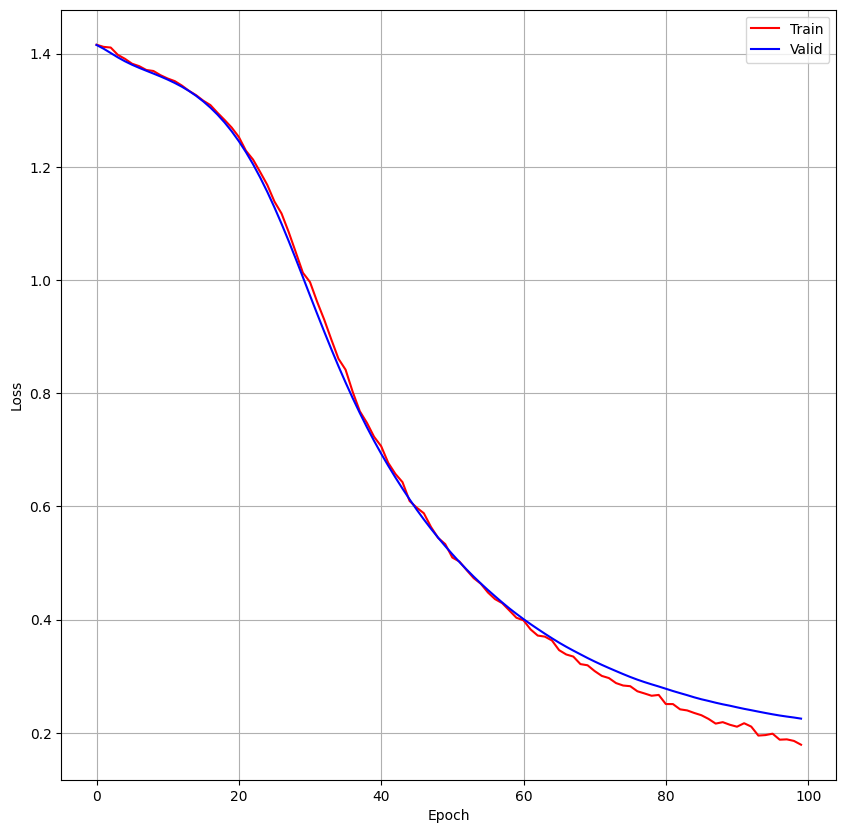

In [121]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(epochs), hist_loss_train, 'r-', label='Train')
ax.plot(range(epochs), hist_loss_valid, 'b-', label='Valid')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True)
ax.legend()

###  Plot (Accuracy)

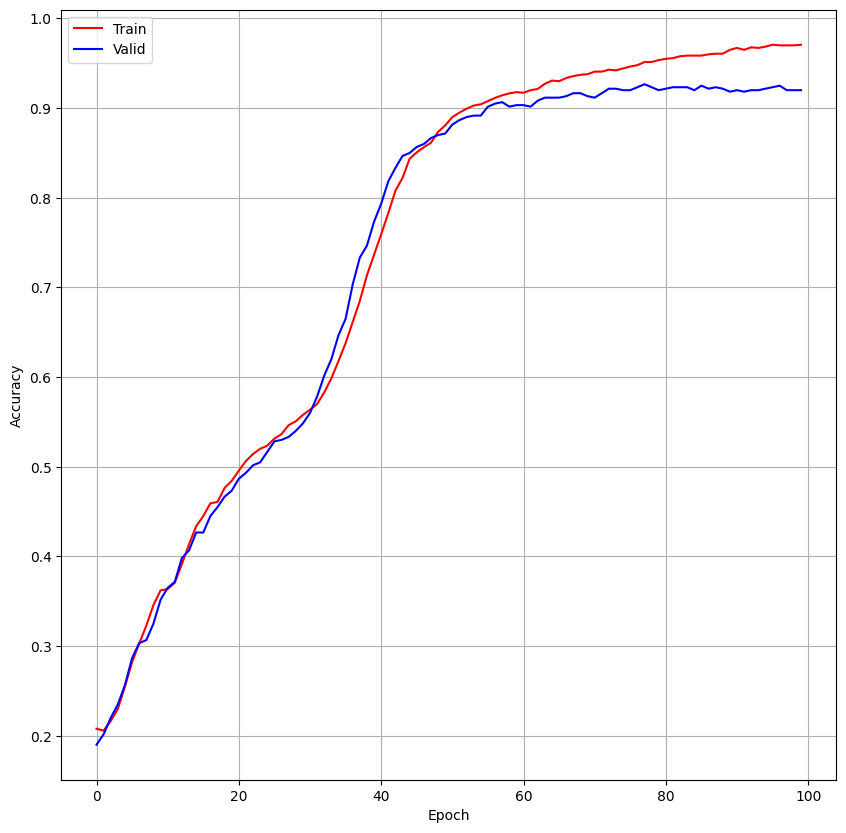

In [122]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(epochs), hist_acc_train, 'r-', label='Train')
ax.plot(range(epochs), hist_acc_valid, 'b-', label='Valid')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()

#### Plot (F1 Score)

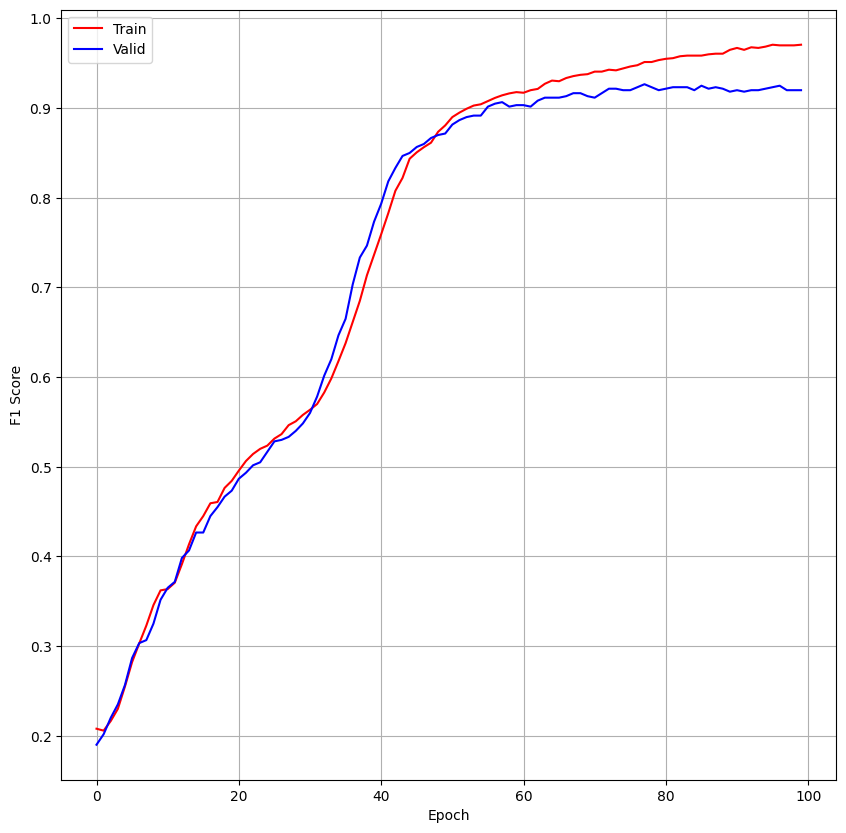

In [123]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(epochs), hist_f1_train, 'r-', label='Train')
ax.plot(range(epochs), hist_f1_valid, 'b-', label='Valid')

ax.set_xlabel('Epoch')
ax.set_ylabel('F1 Score')
ax.grid(True)
ax.legend()

---
### Save Model

In [124]:
torch.save(model, './model.pt')

In [125]:
torch.load('./model.pt', weights_only=False)

Sequential(
  (0): Linear(in_features=20, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
)